# **Marine Heatwaves in the Rockall Trough**

The data was downloaded from https://scotmarphys.github.io/ScotMarPhys.OSNAP-Mooring-Processing.io/. And the algorithm for working with marine heatwaves by Hobday et al. (2016) was downloaded here: https://github.com/ecjoliver/marineHeatWaves. 

In addition ORAS5 was used to calculate an alternative climatology and instead of the gridded data product we used the data from the induvidual instruments.

## Read in packages for this script

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
import xarray as xr
import cmocean as cm
import marineHeatWaves as mhw
from datetime import date
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore")

## **Data and Definintions**

## **Gridded Dataset**
https://scotmarphys.github.io/ScotMarPhys.OSNAP-Mooring-Processing.io/. The depth variable was turned into a coordinate and the dataset was reduced to contain only the temperature data we are interested in. The temperature data was converted from K into °C to make it easier to understand. 

In [55]:
file_name = "data/Rockall-Trough-Mooring-Time-Series-2020.nc"
ds = xr.open_dataset(file_name)

In [56]:
# making DEPTH a coordinate -› allows for calling specific depths (instead of the awkwared 20db grid the ds had before)
ds.coords['DEPTH'] = ds.PRES

In [58]:
# overwrite dataset and select only the variables of interst (temperature data)
ds = ds[['TG_EAST', 'TG_WEST']]

In [59]:
# creating two new variables in the ds that have the unit °C for temperature instead of K

# for TG_EAST
ds['TG_EAST_C'] = ds.TG_EAST-273.15
ds.TG_EAST_C.attrs = ds.TG_EAST.attrs 
ds.TG_EAST_C.attrs['units'] = 'degC'
ds.TG_EAST_C.attrs

# and TG_WEST
ds['TG_WEST_C'] = ds.TG_WEST-273.15
ds.TG_WEST_C.attrs = ds.TG_WEST.attrs 
ds.TG_WEST_C.attrs['units'] = 'degC'
ds.TG_WEST_C.attrs;

## Depth that instruments are located on the moorings
Roughly

In [7]:
depth_E = [100, 250, 500, 750, 1000, 1250, 1500, 1760]
depth_W = [100, 250, 500, 750, 1000, 1250, 1500, 1575]

## **ORAS 5 Dataset**

In [8]:
file_name = "data/ORAS5.nc"
oras5 = xr.open_dataset(file_name)
oras5=oras5.rename({'depth':'DEPTH','time':'TIME'})

In [9]:
oras5_EB= oras5.sel(latitude = 57.1, 
                           longitude = -9.6 -0.5, 
                           method = 'nearest')
oras5_WB = oras5.sel(latitude = 57.5, 
                           longitude = -12.5, 
                           method = 'nearest')

## Resampling the dataset

Before continuing the dataset needs to be resampled to fit the algorithm. By reducing the resolution to 1 day (1D) instead of half days(12 hour periods) the algorithm can work with the data input. When resampling the dataset I made sure that the ds attributes did not get lost.

In [10]:
# resampling the dataset -› so that we have full days instead of half days -› by calculating the mean
ds1D = ds.resample(TIME = "1D").mean(keep_attrs=True);  # making sure that the new 1D data set has the same attributes as the original ds

## A contour plot of the temperature data ds

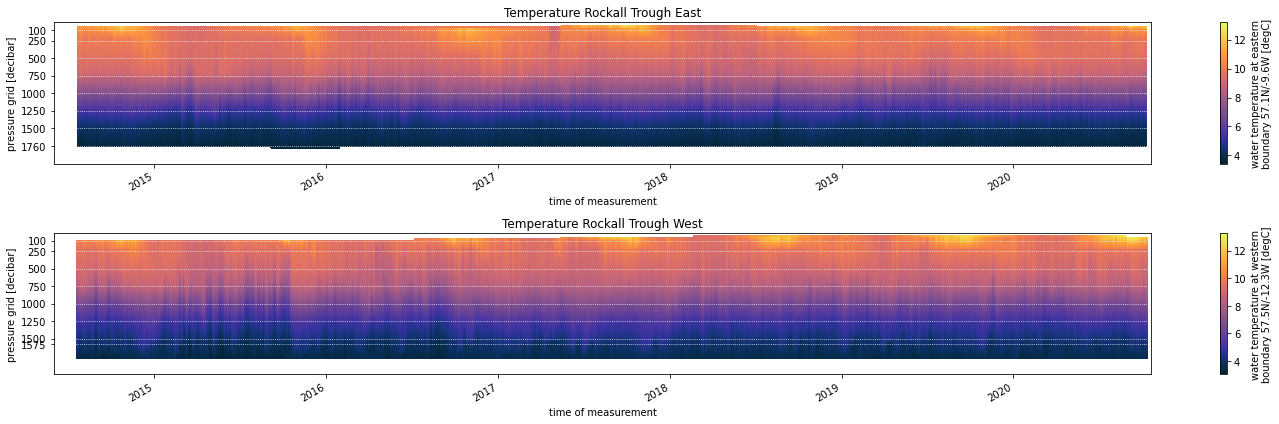

In [11]:
# notes: 
# yincrease = False -› inverts the y-axis, setting ylim = (high, low) does the same (but limets need to be known)
# plot.contourf() creates a plot with more clearly defined contours

fig, ax = plt.subplots(2, 1, figsize = (20, 6))

ds.TG_EAST_C.plot(ax=ax[0], x = 'TIME', y = 'DEPTH', yincrease = False, cmap = cm.cm.thermal, yticks = depth_E);
ax[0].set_title("Temperature Rockall Trough East");
ax[0].yaxis.grid(linestyle =':', color = 'w')

ds.TG_WEST_C.plot(ax=ax[1], x = 'TIME', yincrease = False, cmap = cm.cm.thermal, yticks = depth_W);
ax[1].set_title("Temperature Rockall Trough West");
ax[1].yaxis.grid(linestyle =':', color = 'w')

fig.tight_layout();

#plt.savefig('Temperature overview Rockall Trough East and West', dpi = 300, bbox_inches='tight')

## A contour plot of the ORAS5 data

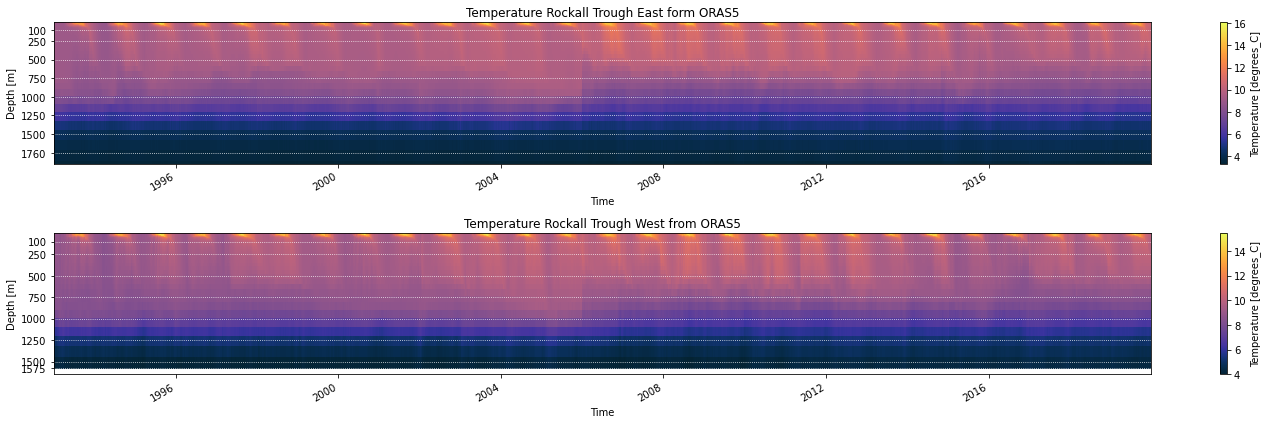

In [12]:
fig, ax = plt.subplots(2, 1, figsize = (20, 6))

oras5_EB.thetao_oras.plot(ax=ax[0], x = 'TIME', yincrease = False, cmap = cm.cm.thermal, yticks = depth_E, ylim=(1900,0));
ax[0].set_title("Temperature Rockall Trough East form ORAS5");
ax[0].yaxis.grid(linestyle =':', color = 'w')

oras5_WB.thetao_oras.plot(ax=ax[1], x = 'TIME', yincrease = False, cmap = cm.cm.thermal, yticks = depth_W, ylim=(1650,0));
ax[1].set_title("Temperature Rockall Trough West from ORAS5");
ax[1].yaxis.grid(linestyle =':', color = 'w')

fig.tight_layout();

## Creating line plots to compare temperature at the surface and bottom EAST and WEST

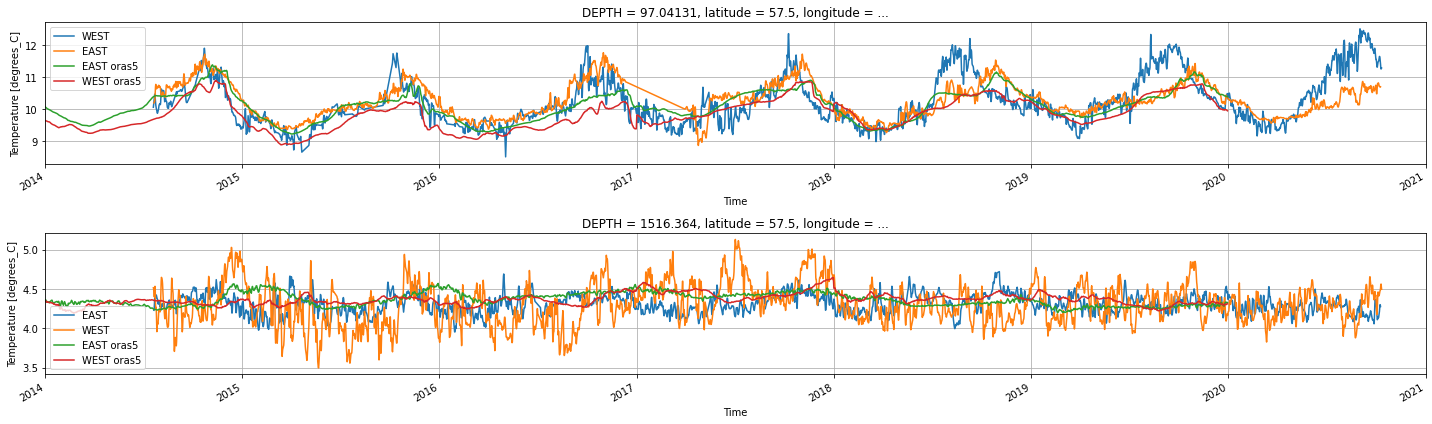

In [13]:
# extracting one temperature profile by slicing the dataset at a specific depth
# creating 4 plots that show the temperature at 100m and 1700m from the eastern and western boundary

fig, ax = plt.subplots(2, 1, figsize = (20, 6))

# 100m plot
ds.TG_WEST_C.sel(DEPTH = 100).plot(ax=ax[0], label = 'WEST', xlim =(np.datetime64('2014'), np.datetime64('2021')));
ds.TG_EAST_C.sel(DEPTH = 100).plot(ax=ax[0], label = 'EAST');
oras5_EB.thetao_oras.sel(DEPTH = 100, method = 'nearest').plot(ax=ax[0], label = 'EAST oras5')
oras5_WB.thetao_oras.sel(DEPTH = 100, method = 'nearest').plot(ax=ax[0], label = 'WEST oras5')

# 1500m plot
ds.TG_EAST_C.sel(DEPTH = 1500).plot(ax=ax[1], label = 'EAST', xlim =(np.datetime64('2014'), np.datetime64('2021')));
ds.TG_WEST_C.sel(DEPTH = 1500).plot(ax=ax[1], label = 'WEST');
oras5_EB.thetao_oras.sel(DEPTH = 1500, method = 'nearest').plot(ax=ax[1], label = 'EAST oras5')
oras5_WB.thetao_oras.sel(DEPTH = 1500, method = 'nearest').plot(ax=ax[1], label = 'WEST oras5')


for axs in ax: 
    axs.legend()
    axs.grid()
#ax[1].legend()

fig.tight_layout();

# **Functions (and Working with the algorithm)** MHWs

## **Functions** 

### MHW_func definines the variables that go into the algorithm and then gives out algorithm varaibles

The function below defines the varibles I want I can use an iteration to get all my datapoints for all desired depth (the ones that actually have an instrument and are not intrapolated) and save the output to a dictionary.

In [14]:
# creating a function so I can iterate through all depths later

def MHW_func (data, depth, climP=[2014.0,2020.0], altClim=False):
    yy_start = int(data.TIME[0].dt.year)
    yy_end = int(data.TIME[-1].dt.year)
    mm_start = int(data.TIME[0].dt.month)
    mm_end = int(data.TIME[-1].dt.month)
    dd_start = int(data.TIME[0].dt.day)
    dd_end = int(data.TIME[-1].dt.day)
    
    t = np.arange(
        date(yy_start, mm_start, dd_start).toordinal(),                 # .toordinal turns the date into a number that the algorithm can process
        date(yy_end, mm_end, dd_end).toordinal()+1,1) 
    
    temp = data.sel(DEPTH=depth, method = 'nearest').squeeze().values   # by using .squeeze().values we are first removing any other depth and then turning the data into a 1d numpy array 
                                                                        # without doing this the data will still be in an array and the algorithm can't handle it
    
    mhws, clim = mhw.detect(t, temp, climatologyPeriod=climP, alternateClimatology=altClim)                                    # using the algorithm
    mcss, clim_cold = mhw.detect(t, temp, coldSpells = True, climatologyPeriod=climP, alternateClimatology=altClim)            # cold spells 
    return mhws, mcss, clim, clim_cold, t, temp  

### DICT_func 
... creates dictionaries with all information to be used by the other functions...

In [15]:
# only works for the gridded data... we did not get it to work for the ORAS data when we tried to use an altClim

def DICT_func(data, depth, climP=[2014,2020], altClim= False, altT=False, altData=False):  
    # define 6 empty dictionaries
    mhws_,mcss_,clim_,clim_cold_,t_,temp_ = {},{},{},{},{},{}

    # Iterating through all instrument depths       
    for n in depth:
        
        if altClim:
            temp_oras = np.array(altData.sel(DEPTH=n, method= 'nearest'))
            altClim=[altT,temp_oras]

        mhws, mcss, clim, clim_cold, t, temp = MHW_func(data, n, climP=climP, altClim=altClim)
        mhws_.update({str(n):mhws})
        mcss_.update({str(n):mcss})
        clim_.update({str(n):clim})
        clim_cold_.update({str(n):clim_cold})
        t_.update({str(n):t})
        temp_.update({str(n):temp})
    
    dictionary = {'mhws':mhws_,'mcss':mcss_,'clim':clim_,'clim_cold':clim_cold_,'t':t_,'temp':temp_}
    return dictionary

### ALL_events

In [16]:
def ALL_events(dict, n):
    
    #defining my variables
    mhws = dict['mhws'][str(n)]
    mcss = dict['mcss'][str(n)]
    t = dict['t'][str(n)]
    temp = dict['temp'][str(n)]
    clim = dict['clim'][str(n)]
    clim_cold = dict['clim_cold'][str(n)]
    
    dates = [date.fromordinal(tt.astype(int)) for tt in t]

    ev = (mhws['n_events'])
    ec = (mcss['n_events'])


    plt.figure(figsize=(30,15))
    plt.subplot(2,1,1)

    # Plot t, seasonal cycle, and threshold
    plt.plot(dates, clim['thresh'], ':r', label = 'Threshold warm')
    plt.plot(dates, clim_cold['thresh'], ':g', label = 'Threshold cold')
    plt.plot(dates, temp, 'k', label = 'Temperature', linewidth = .75)
    plt.plot(dates, clim['seas'], 'b', label = 'Climatology')
    plt.legend()
    plt.title('Data Overview')
    plt.xlim(dates[0], dates[-1])
    #plt.xlim(date(2016,1,1), date(2017,5,1))
    plt.ylim(temp.min()-0.1, temp.max()+0.1)
    plt.ylabel(r't $^\circ$C')
    plt.grid()

    # plt the heatwaves
    plt.subplot(2,1,2)

    # Find all MHWs and shade
    for ev0 in np.arange (ev):
        t1 = np.where(t==mhws['time_start'][ev0])[0][0]
        t2 = np.where(t==mhws['time_end'][ev0])[0][0]
        plt.fill_between(dates[t1:t2+1], temp[t1:t2+1], clim['thresh'][t1:t2+1], \
                         color='pink')

    # Find MHW of interest and shade accordingly
    ev_i = np.argmax(mhws['intensity_max'])
    t1 = np.where(t==mhws['time_start'][ev_i])[0][0]
    t2 = np.where(t==mhws['time_end'][ev_i])[0][0]
    plt.fill_between(dates[t1:t2+1], temp[t1:t2+1], clim['thresh'][t1:t2+1], \
                     color='deeppink', label = 'MHW event with max intensity')


    # same for cold spells
    for ec0 in np.arange(ec):
        tc1 = np.where(t==mcss['time_start'][ec0])[0][0]
        tc2 = np.where(t==mcss['time_end'][ec0])[0][0]
        plt.fill_between(dates[tc1:tc2+1], temp[tc1:tc2+1], clim_cold['thresh'][tc1:tc2+1], \
                         color='cyan')

    # Find MCSS of interest and shade accordingly
    ec_i = np.argmin(mcss['intensity_max'])
    tc1 = np.where(t==mcss['time_start'][ec_i])[0][0]
    tc2 = np.where(t==mcss['time_end'][ec_i])[0][0]
    plt.fill_between(dates[tc1:tc2+1], temp[tc1:tc2+1], clim_cold['thresh'][tc1:tc2+1], \
                     color='darkcyan', label = 'MCSS event with max intensity')    

    # Plot t, seasonal cycle, threshold, shade MHWs with main event in red
    plt.plot(dates, clim['thresh'], ':r', linewidth=2, label = 'Threshold warm')
    plt.plot(dates, clim_cold['thresh'], ':g', linewidth=2, label = 'Threshold cold')
    plt.plot(dates, temp, 'k', linewidth=.75, label = 'Temperature')
    plt.plot(dates, clim['seas'], 'b', linewidth=2, label = 'Climatology')
    plt.legend()
    plt.title('Marine Heatwaves and Cold Spells')
    #plt.xlim(date(2016,1,1), date(2016,12,31))
    plt.xlim(dates[0], dates[-1])
    #plt.xlim(mhws['date_start'][ev-12], mhws['date_end'][ev+4])
    plt.ylim(temp.min()-0.1, temp.max()+0.1)
    plt.grid()
    plt.ylabel(r't $^\circ$C');
    
    #print some intersting stats
    print('Overview:')
    print('Number of MHWs: ', ev)
    print('Number of MCSs: ', ec)
    print('The MHWs of max intensity lastet from the', mhws['date_start'][ev_i], 'to the', mhws['date_end'][ev_i])
    print('The MCSs of max intensity lastet from the', mcss['date_start'][ec_i], 'to the', mcss['date_end'][ec_i])
    print(' ')

#plt.savefig('100m_EAST_zoom_2016-2017', dpi = 300)

### MHW_details gives out some key details for the chosen MHW

In [17]:
def MHW_details(mhws,i):
    i = i-1
    print('Number of MHWs:', mhws['n_events'])
    print('MHW number:', i+1)
    print('Start Date:', mhws['date_start'][i])
    print('End Date:', mhws['date_end'][i])
    print('Duration:', mhws['duration'][i], 'days')
    print('Max intensity relative to clim:', '%.3f' % mhws['intensity_max'][i])
    print('Max intensity relative to thresh:', '%.3f' % mhws['intensity_max_relThresh'][i])
    print('Max absolute temp:', '%.5f' % mhws['intensity_max_abs'][i])
    print('———————')

### MHW_plot

In [18]:
#fig, ax = plt.subplots(3,1, figsize= (15,5))
def MHW_plot(t,temp,clim,ax):

    
    ax.plot(t,temp,label='temp', color='grey', linewidth='.75')
    ax.plot(t,clim['seas'],label='clim', color='b')
    ax.plot(t,clim['thresh'], label='thresh', color='r')
    #plt.plot(ds1D.TIME,clim_cold['thresh'], label='thresh')
    ax.legend()

    yloc = YearLocator()
    mloc = MonthLocator()
    ax.xaxis.set_major_locator(yloc)
    ax.xaxis.set_minor_locator(mloc)

    ax.grid()

### MHW_stats

In [19]:
def MHW_stats(t, mhws, title=False, title_str=None):
    mhwBlock = mhw.blockAverage(t, mhws)

    fig, ax = plt.subplots(1,2, figsize=(14,4), sharex = True)
    plt.subplot(1,2,1)
    plt.plot(mhwBlock['years_centre'], mhwBlock['count'], '-o')
    plt.ylim(0,9)
    plt.ylabel('[count]')
    plt.title('Number of MHWs by year')


    plt.subplot(1,2,2)
    plt.plot(mhwBlock['years_centre'], mhwBlock['intensity_max'], '-o')
    plt.ylabel(r'[$^\circ$C]')
    plt.xlim(mhwBlock['years_centre'][0]-.5 ,mhwBlock['years_centre'][-1]+.5)
    plt.title('Average MHW maximum intensity by year')
    
    #ax[1].set_xlim(ax[0].get_xlim())
    fig.tight_layout
    
    if title:
        fig.suptitle(title_str)
    

# **Calculations and Plotting**

## **Dictionary Definition EAST MHW**

In [20]:
EAST = DICT_func(ds1D.TG_EAST_C, depth_E)
WEST = DICT_func(ds1D.TG_WEST_C, depth_W)

## Calculating an alternative clim
### Problem with our dataset EAST -› alt clim and cutting out bad data
The data we have for 100m depth is intrapolated between 12/2016 amd 06/2016 & then followed by a weird spike -› that is taken into account when the algorithm calculates the climatology which causes problems because it does not represent what is actually happening at 100db. To avoid the problem I will replace the data tha is stored in the dictionary at 100m with alternative data that sets all "funny" values to NaNs. 


In [21]:
# define variables so I can plot both versions in the sam figure further below

temp_100_orig = EAST['temp']['100']
clim_100_orig = EAST['clim']['100']

I am redefinig the dictionary for 100m depth to exclude the problematic data and set it NaN instead so that it is not taken into account when the algorithm calculates the climatology

In [22]:
# Creating a new dataset called dsNC (dsNewClim) -› it includes 5 full years of data
    
dsNC = xr.concat([ds1D.sel(TIME = slice('2014-6-1', '2016-5-31')), ds1D.sel(TIME = slice('2017-6-1', '2020-5-31'))],dim='TIME')

In [23]:
# alternative timeline
t_alt = np.concatenate((np.arange(
        date(2014,6,1).toordinal(),
        date(2016,5,31).toordinal()+1,1), 
        np.arange(
        date(2017,6,1).toordinal(),
        date(2020,5,31).toordinal()+1,1)))

# alternative temperature
temp_alt = dsNC.TG_EAST_C.sel(DEPTH=100).squeeze().values 
temp_100 = ds1D.TG_EAST_C.sel(DEPTH=100)
temp_100 = temp_100.where((temp_100.TIME<np.datetime64('2016-12-10')) | (temp_100.TIME>np.datetime64('2017-05-17'))).squeeze().values

In [24]:
## overwriting the dictionary with the alternative data

#EAST['t']['100'] = t_alt ### do not adapt t_alt... we need the full time series!
EAST['temp']['100'] = temp_100
t_100 = EAST['t']['100']

mhws_alt, clim_alt = mhw.detect(t_100,temp_100,climatologyPeriod= [2014.0, 2020.0],alternateClimatology=[t_alt,temp_alt])
EAST['mhws']['100'] = mhws_alt
EAST['clim']['100'] = clim_alt

mcss_alt, clim_cold_alt = mhw.detect(t_100,temp_100,climatologyPeriod= [2014.0, 2020.0],alternateClimatology=[t_alt,temp_alt], coldSpells=True)
EAST['mcss']['100'] = mcss_alt
EAST['clim_cold']['100'] = clim_cold_alt

Below are the plots for 100m with the original data and the improved data. 

In [25]:
temp_100_alt = EAST['temp']['100'] 
clim_100_alt = EAST['clim']['100'] 

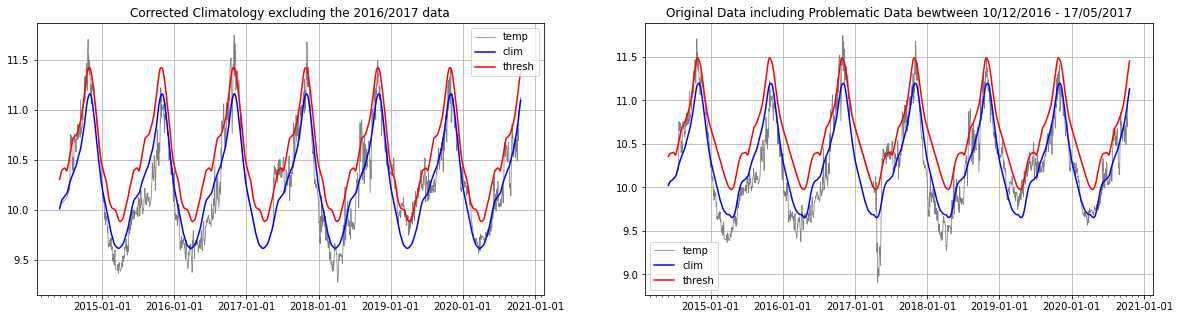

In [26]:
# stimmt nicht
fig, ax = plt.subplots(1,2, figsize= (20,5))

MHW_plot(ds1D.TIME, temp_100_alt, clim_100_alt, ax[0])
ax[0].set_title('Corrected Climatology excluding the 2016/2017 data');

MHW_plot(ds1D.TIME, temp_100_orig, clim_100_orig, ax[1])
ax[1].set_title('Original Data including Problematic Data bewtween 10/12/2016 - 17/05/2017');

## Alternative clim from the ORAS5 data

In [27]:
## stimmt nicht 
#
#t_oras = np.arange(
#            date(1993,1,1).toordinal(),
#            date(2019,12,31).toordinal()+1,1)#
#
#oras5_EB.thetao_oras_10 = DICT_func(ds1D.TG_EAST_C, depth_E, climP=[2010,2019], altT=t_oras, altData=oras5_EB.thetao_oras)
#oras5_EB.thetao_oras_all = DICT_func(ds1D.TG_EAST_C, depth_E, climP=[1993,2019], altT=t_oras, altData=oras5_EB.thetao_oras)

In [28]:
# alt clim from ORAS5 -› take only last 10 years of data
mhws_EB_10,mcss_EB_10,clim_EB_10,clim_cold_EB_10,t_EB_10,temp_EB_10 = {},{},{},{},{},{}

t_oras = np.arange(
        date(1993,1,1).toordinal(),
        date(2019,12,31).toordinal()+1,1)

# Iterating through all instrument depths
for n in depth_E: 
    temp_oras = np.array(oras5_EB.thetao_oras.sel(DEPTH=n, method= 'nearest'))
    
    mhws, mcss, clim, clim_cold, t, temp = MHW_func(ds1D.TG_EAST_C, n, climP=[2010,2019], altClim=[t_oras,temp_oras])
    mhws_EB_10.update({str(n):mhws})
    mcss_EB_10.update({str(n):mcss})
    clim_EB_10.update({str(n):clim})
    clim_cold_EB_10.update({str(n):clim_cold})
    t_EB_10.update({str(n):t})
    temp_EB_10.update({str(n):temp})
    
oras5_EB_10 = {'mhws':mhws_EB_10,'mcss':mcss_EB_10,'clim':clim_EB_10,'clim_cold':clim_cold_EB_10,'t':t_EB_10,'temp':temp_EB_10}

In [29]:
# alt clim from ORAS5 -› all years
mhws_EB_all,mcss_EB_all,clim_EB_all,clim_cold_EB_all,t_EB_all,temp_EB_all = {},{},{},{},{},{}

t_oras = np.arange(
        date(1993,1,1).toordinal(),
        date(2019,12,31).toordinal()+1,1)

# Iterating through all instrument depths
for n in depth_E: 
    temp_oras = np.array(oras5_EB.thetao_oras.sel(DEPTH=n, method= 'nearest'))
    
    mhws, mcss, clim, clim_cold, t, temp = MHW_func(ds1D.TG_EAST_C, n, climP=[1993,2019], altClim=[t_oras,temp_oras])
    mhws_EB_all.update({str(n):mhws})
    mcss_EB_all.update({str(n):mcss})
    clim_EB_all.update({str(n):clim})
    clim_cold_EB_all.update({str(n):clim_cold})
    t_EB_all.update({str(n):t})
    temp_EB_all.update({str(n):temp})
    
oras5_EB_all = {'mhws':mhws_EB_all,'mcss':mcss_EB_all,'clim':clim_EB_all,'clim_cold':clim_cold_EB_all,'t':t_EB_all,'temp':temp_EB_all}

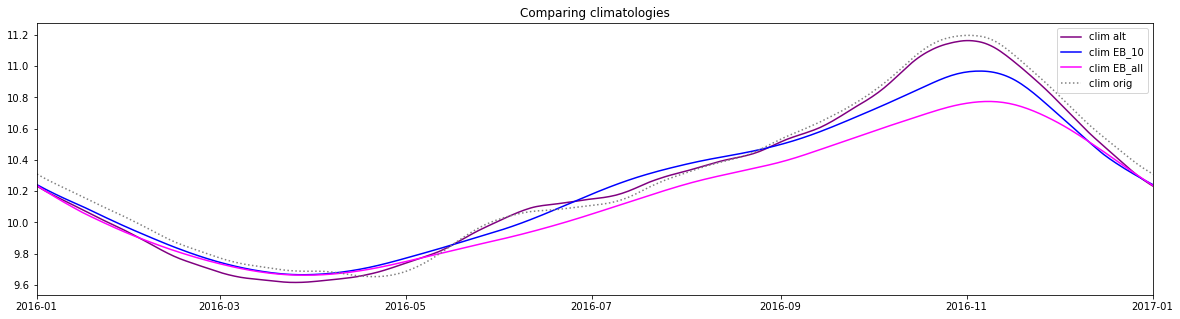

In [30]:
# climatologies compared
dates_EB_10 = [date.fromordinal(tt.astype(int)) for tt in oras5_EB_10['t']['100']]
dates_EB_all = [date.fromordinal(tt.astype(int)) for tt in oras5_EB_all['t']['100']]

fig = plt.figure(figsize=(20,5))
plt.xlim(np.datetime64('2016'), np.datetime64('2017')) 
plt.plot(ds1D.TIME, EAST['clim']['100']['seas'], 'purple', label='clim alt')
plt.plot(dates_EB_10, oras5_EB_10['clim']['100']['seas'], 'b', label='clim EB_10')
plt.plot(dates_EB_all, oras5_EB_all['clim']['100']['seas'], 'magenta', label='clim EB_all')
plt.plot(ds1D.TIME, clim_100_orig['seas'], 'grey', linestyle=':', label='clim orig')
plt.title('Comparing climatologies')
plt.legend();

## Create Plots

### **Stats Plots**

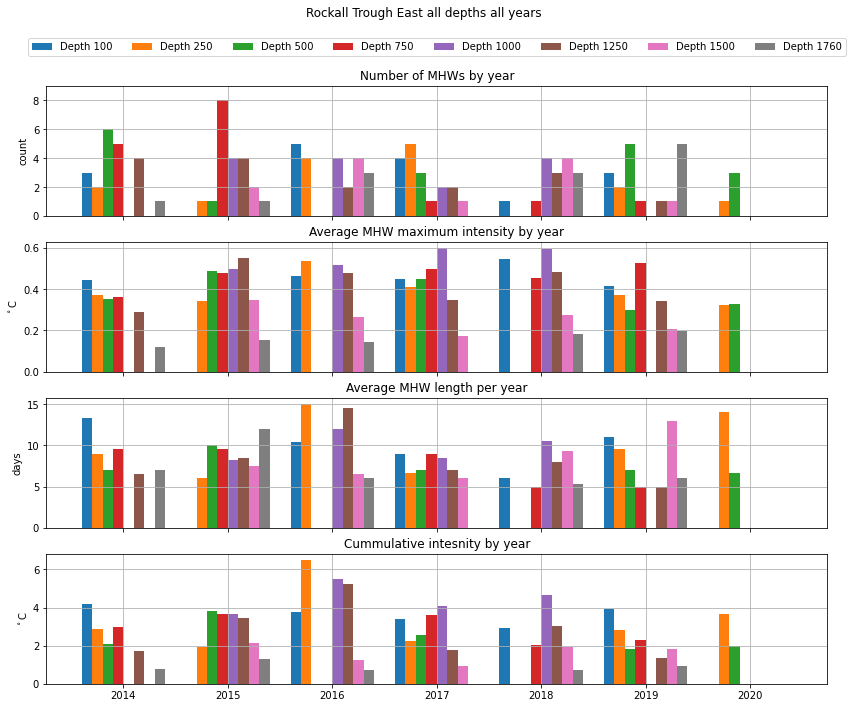

In [31]:
# stats plots EAST
# create stats plots that plot all depths in one
# colormap = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, axs = plt.subplots(4,1, figsize=(14,11), sharex = True)
fig.suptitle('Rockall Trough East all depths all years')
width=0.1 
dt = np.arange(-0.35,0.36,width)  
for i,n in enumerate(depth_E):
    mhws, t= EAST['mhws'][str(n)], EAST['t'][str(n)]
    mhwBlock = mhw.blockAverage(t, mhws)
    
    axs[0].bar(mhwBlock['years_centre']+dt[i], mhwBlock['count'], width, label = 'Depth '+ str(n))
    axs[1].bar(mhwBlock['years_centre']+dt[i], mhwBlock['intensity_max'], width, label = 'Depth '+ str(n))
    axs[2].bar(mhwBlock['years_centre']+dt[i], mhwBlock['duration'], width, label = 'Depth '+ str(n))
    axs[3].bar(mhwBlock['years_centre']+dt[i], mhwBlock['intensity_cumulative'], width, label = 'Depth '+ str(n))
    #print(mhwBlock['years_centre'][0]+dt[i])
    
axs[0].set_ylim(0,9)
axs[0].set_ylabel('count')
axs[0].set_title('Number of MHWs by year')
axs[0].legend(loc='center', bbox_to_anchor=(.5, 1.3), ncol = 8)
    
axs[1].set_ylabel(r'$^\circ$C')
axs[1].set_title('Average MHW maximum intensity by year')

axs[2].set_ylabel('days')
axs[2].set_title('Average MHW length per year')

axs[3].set_ylabel(r'$^\circ$C')
axs[3].set_title('Cummulative intesnity by year')

for i in axs:
    i.grid()

fig.tight_layout;
#fig.legend(bbox_to_anchor=(0, .5))
#plt.savefig('stats_plots_EAST/TG_EAST_C', dpi = 300)

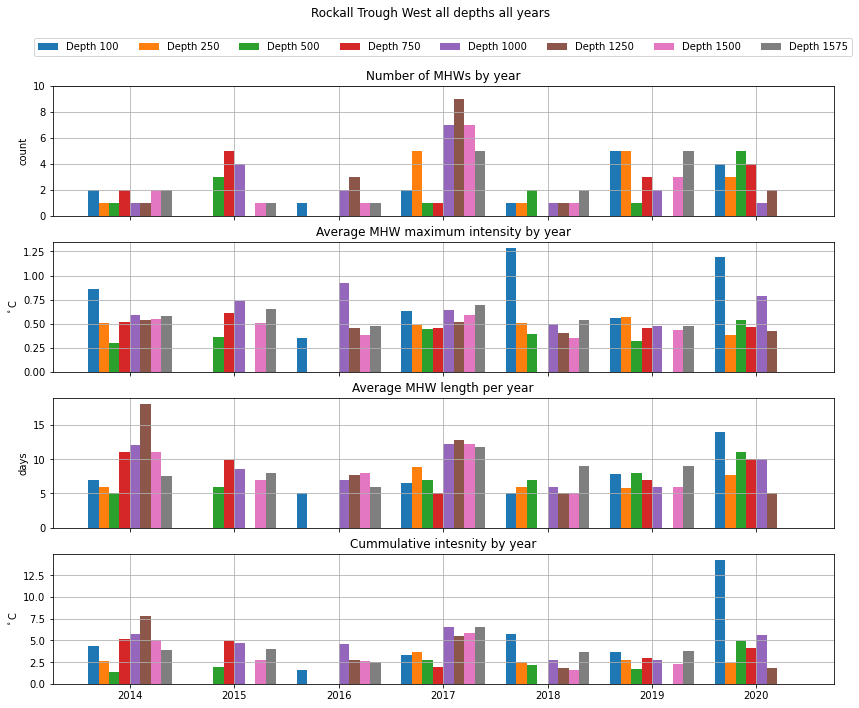

In [32]:
# stats plots WEST 

fig, axs = plt.subplots(4,1, figsize=(14,11), sharex = True)
fig.suptitle('Rockall Trough West all depths all years')
width=0.1 
dt = np.arange(-0.35,0.36,width)  
for i,n in enumerate(depth_W):
    mhws, t= WEST['mhws'][str(n)], WEST['t'][str(n)]
    mhwBlock = mhw.blockAverage(t, mhws)
    
    axs[0].bar(mhwBlock['years_centre']+dt[i], mhwBlock['count'], width, label = 'Depth '+ str(n))
    axs[1].bar(mhwBlock['years_centre']+dt[i], mhwBlock['intensity_max'], width, label = 'Depth '+ str(n))
    axs[2].bar(mhwBlock['years_centre']+dt[i], mhwBlock['duration'], width, label = 'Depth '+ str(n))
    axs[3].bar(mhwBlock['years_centre']+dt[i], mhwBlock['intensity_cumulative'], width, label = 'Depth '+ str(n))
    #print(mhwBlock['years_centre'][0]+dt[i])
    
axs[0].set_ylim(0,10)
axs[0].set_ylabel('count')
axs[0].set_title('Number of MHWs by year')
axs[0].legend(loc='center', bbox_to_anchor=(.5, 1.3), ncol = 8)
    
axs[1].set_ylabel(r'$^\circ$C')
axs[1].set_title('Average MHW maximum intensity by year')

axs[2].set_ylabel('days')
axs[2].set_title('Average MHW length per year')

axs[3].set_ylabel(r'$^\circ$C')
axs[3].set_title('Cummulative intesnity by year')

for i in axs:
    i.grid()

fig.tight_layout;
#fig.legend(bbox_to_anchor=(0, .5))
#plt.savefig('stats_plots_EAST/TG_EAST_C', dpi = 300)

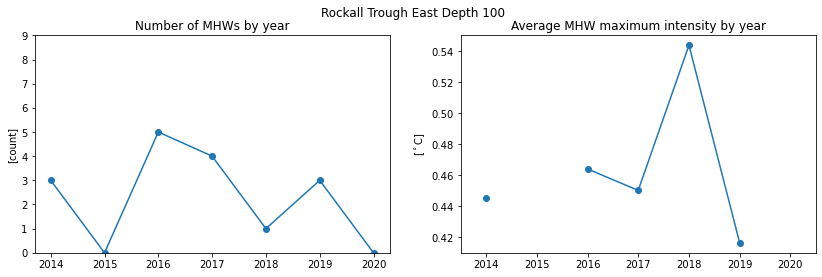

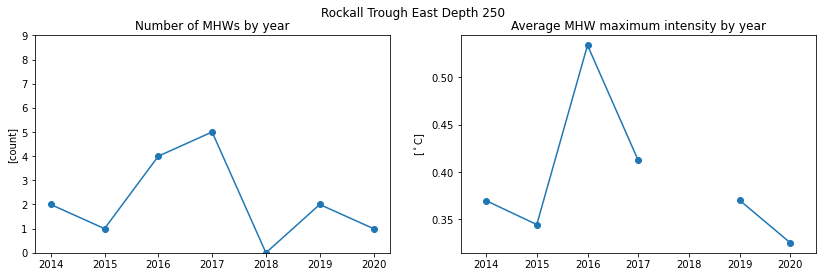

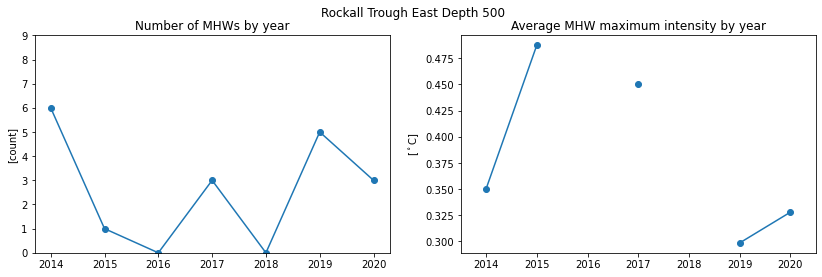

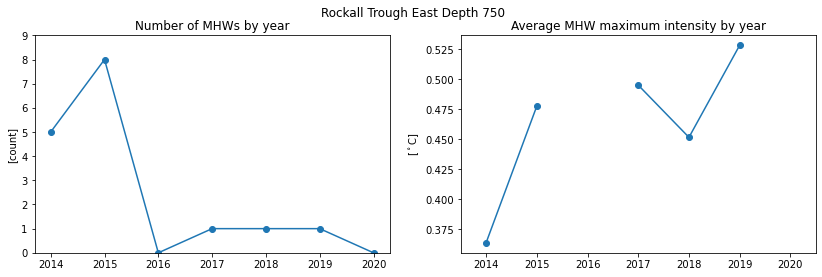

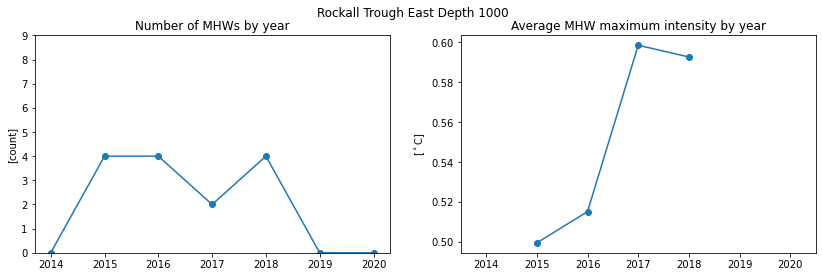

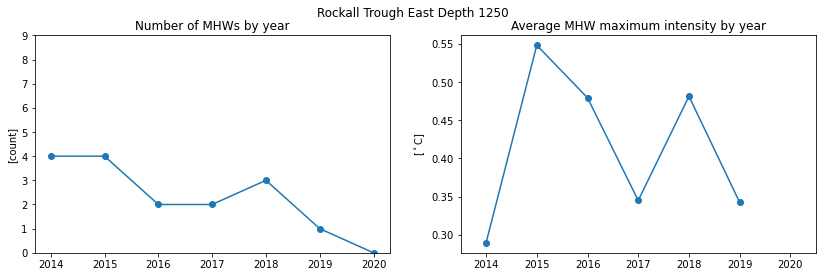

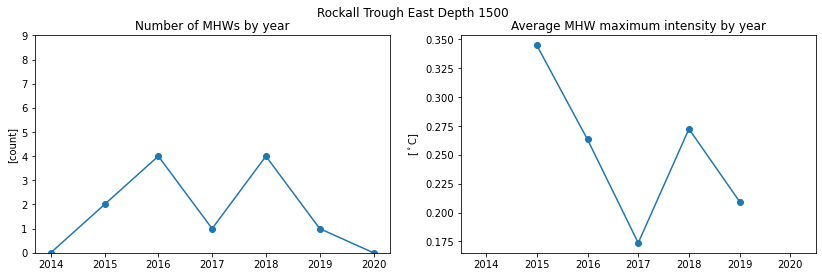

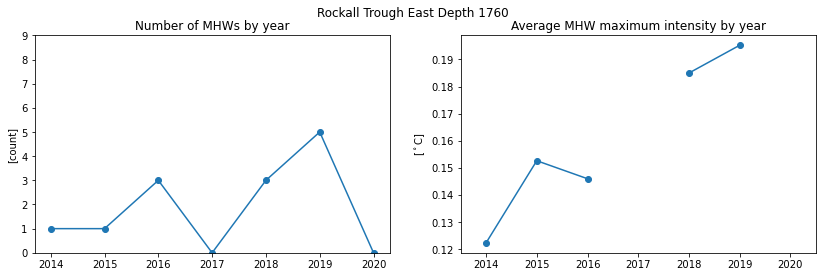

In [33]:
# how useful are they??
# create stats plots EAST

for n in depth_E:
    mhws, t = EAST['mhws'][str(n)], EAST['t'][str(n)]
    MHW_stats(t, mhws,  title = True, title_str='Rockall Trough East Depth ' + str(n))
    
    #plt.savefig('stats_plots_EAST/TG_EAST_C' + str(n), dpi = 300)

### **MHW plot** 
example ... this function has becom a bit unncessisary now that I have defined ALL_events

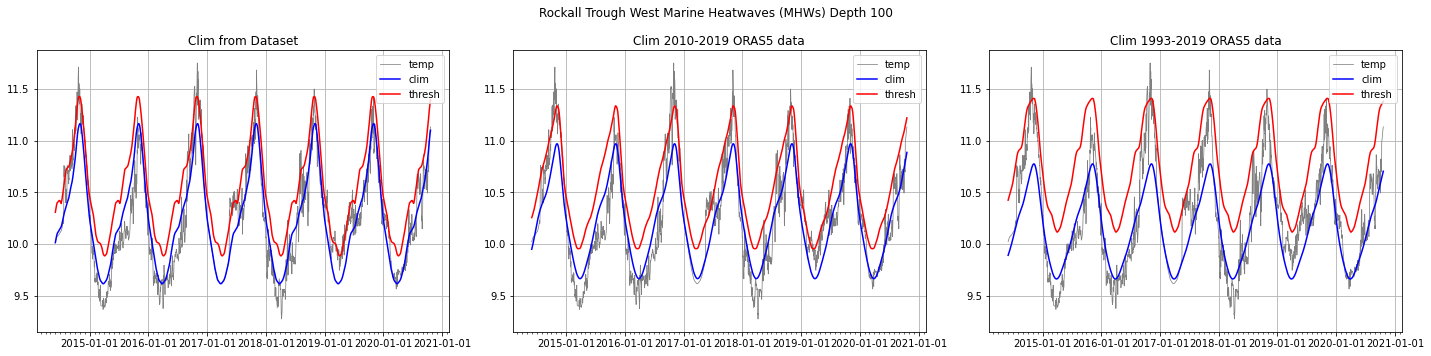

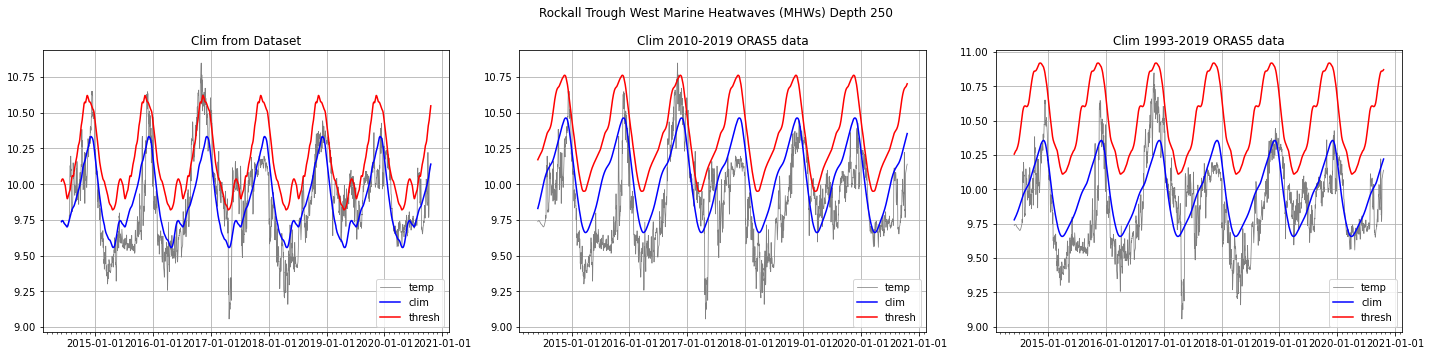

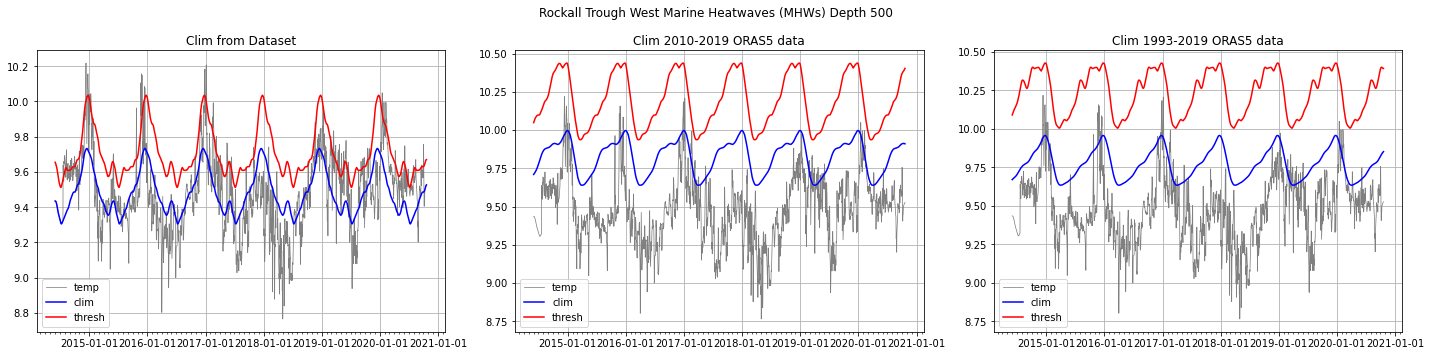

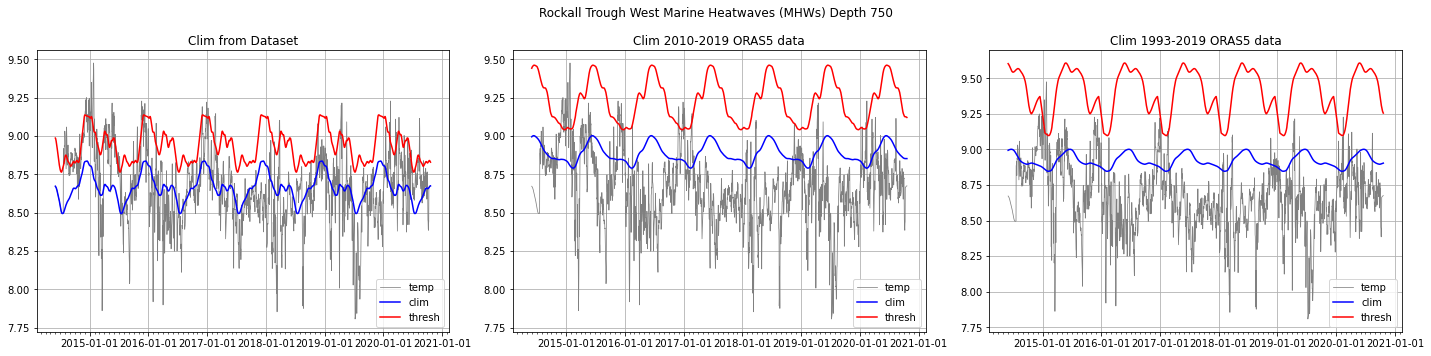

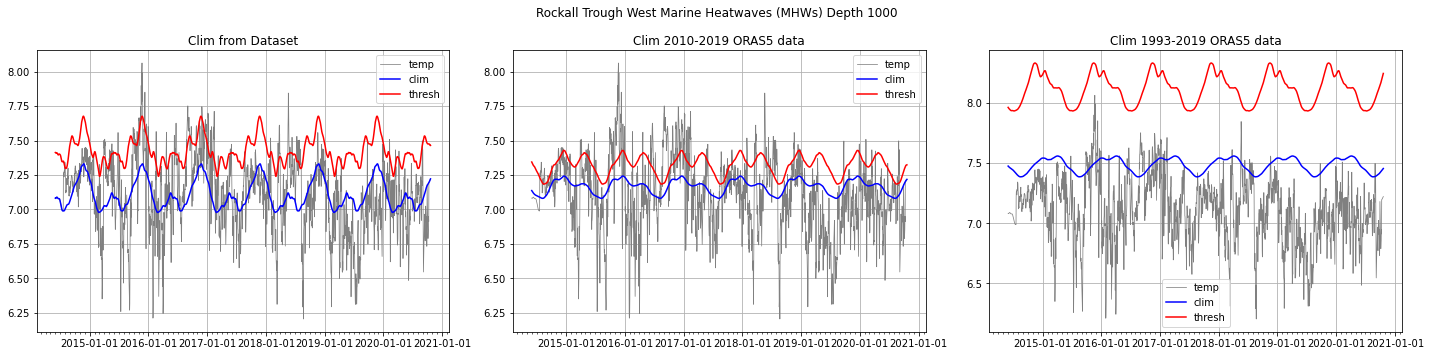

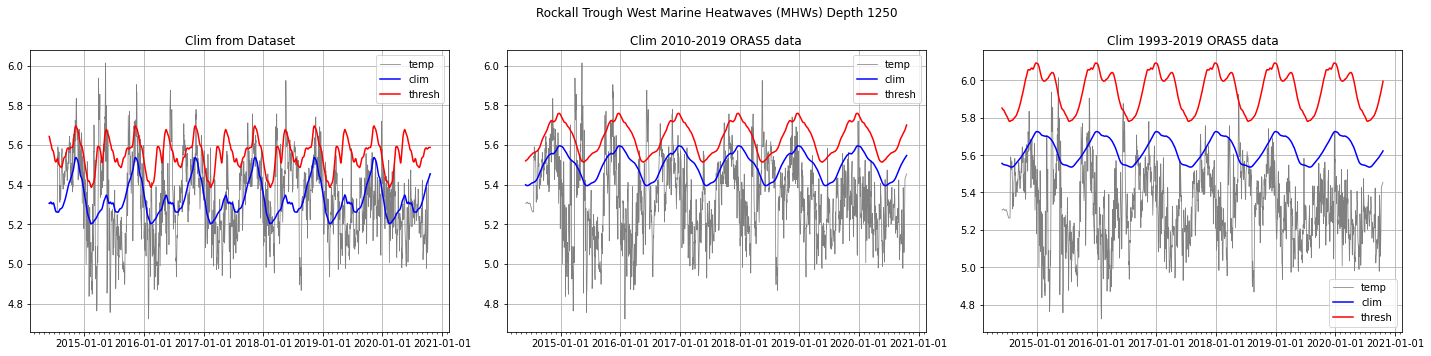

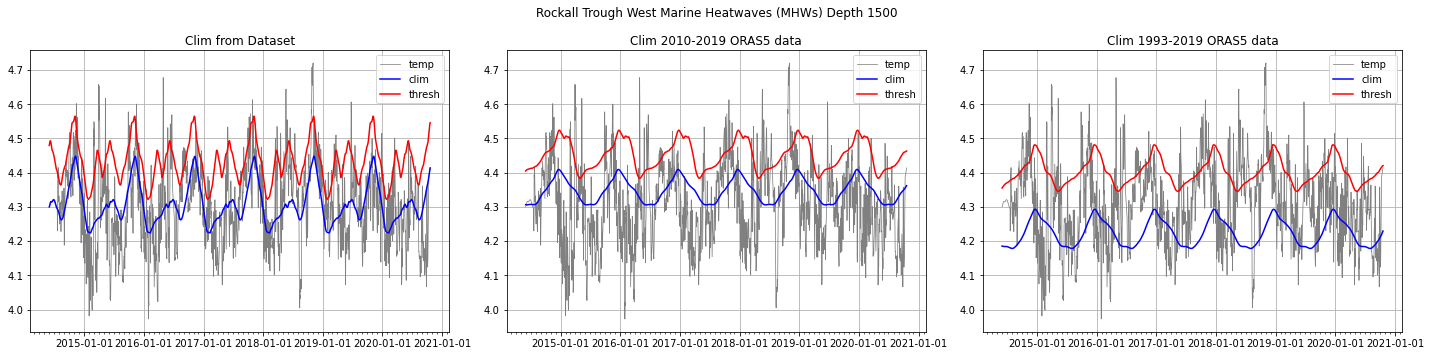

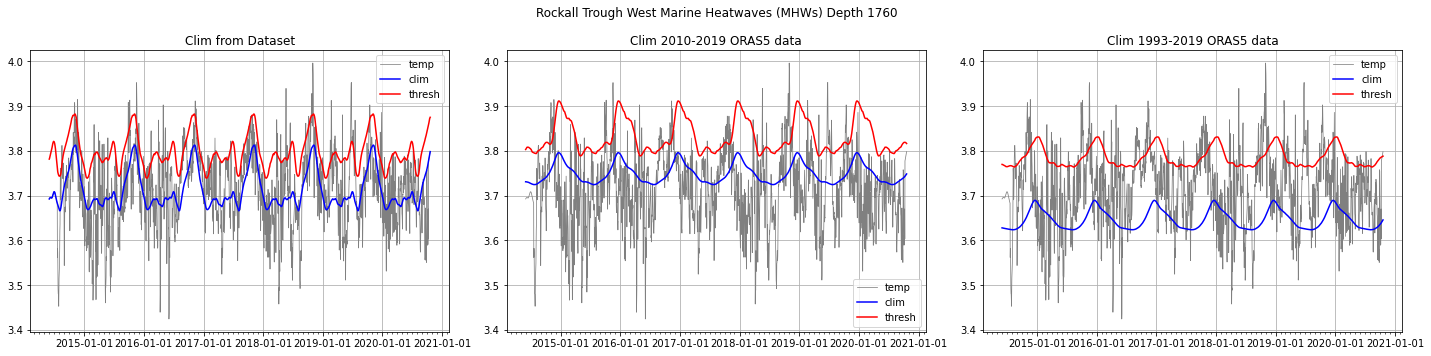

In [34]:
for n in depth_E:
    fig, ax = plt.subplots(1,3, figsize= (20,5))
    fig.suptitle('Rockall Trough West Marine Heatwaves (MHWs) Depth ' + str(n))
    MHW_plot(ds1D.TIME,EAST['temp'][str(n)],EAST['clim'][str(n)],ax[0])
    ax[0].set_title('Clim from Dataset')
    MHW_plot(ds1D.TIME,EAST['temp'][str(n)],oras5_EB_10['clim'][str(n)],ax[1])
    ax[1].set_title('Clim 2010-2019 ORAS5 data')
    MHW_plot(ds1D.TIME,EAST['temp'][str(n)],oras5_EB_all['clim'][str(n)],ax[2])
    ax[2].set_title('Clim 1993-2019 ORAS5 data')
    fig.tight_layout()
    #plt.savefig('figures_WEST/TG_WEST_C_cold' + str(n), dpi = 300)

### **MHW details function**

In [35]:
## Iterate through dictionary by depth (name) and print dtails

#for n in depth_E:
#    print (n)
#    MHW_details(EAST['mhws'][str(n)],1)

for n in np.arange(1,10):
    MHW_details(EAST['mhws']['100'],n)


Number of MHWs: 16
MHW number: 1
Start Date: 2014-07-24
End Date: 2014-08-02
Duration: 10 days
Max intensity relative to clim: 0.467
Max intensity relative to thresh: 0.188
Max absolute temp: 10.75900
———————
Number of MHWs: 16
MHW number: 2
Start Date: 2014-10-20
End Date: 2014-10-24
Duration: 5 days
Max intensity relative to clim: 0.583
Max intensity relative to thresh: 0.293
Max absolute temp: 11.70921
———————
Number of MHWs: 16
MHW number: 3
Start Date: 2014-11-21
End Date: 2014-12-15
Duration: 25 days
Max intensity relative to clim: 0.286
Max intensity relative to thresh: 0.061
Max absolute temp: 11.24187
———————
Number of MHWs: 16
MHW number: 4
Start Date: 2016-08-29
End Date: 2016-09-11
Duration: 14 days
Max intensity relative to clim: 0.503
Max intensity relative to thresh: 0.229
Max absolute temp: 11.06186
———————
Number of MHWs: 16
MHW number: 5
Start Date: 2016-10-08
End Date: 2016-10-16
Duration: 9 days
Max intensity relative to clim: 0.506
Max intensity relative to thresh:

## EAST 100m plot with ORAS5 clim

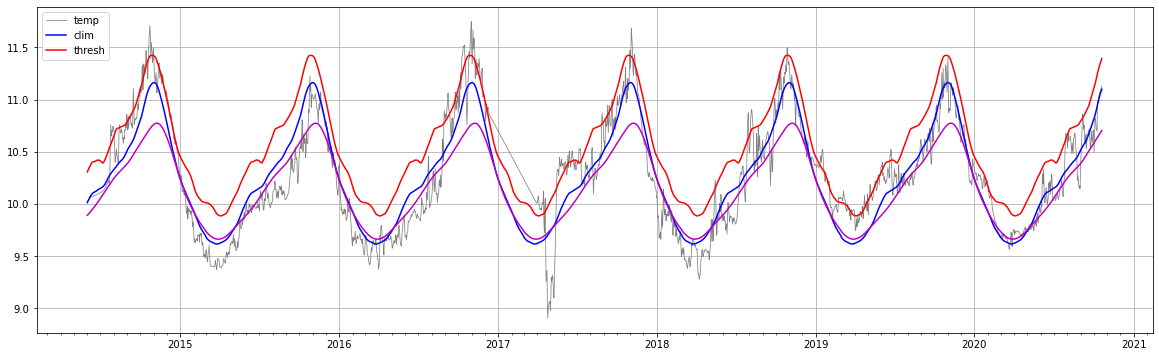

In [36]:
fig, ax= plt.subplots(1,1, figsize = (20,6))

MHW_plot(ds1D.TIME, ds1D.TG_EAST_C.sel(DEPTH=100), EAST['clim']['100'],ax)
plt.plot(dates_EB_all, oras5_EB_all['clim']['100']['seas'], 'm');

Overview:
Number of MHWs:  15
Number of MCSs:  20
The MHWs of max intensity lastet from the 2017-06-30 to the 2017-07-14
The MCSs of max intensity lastet from the 2015-05-20 to the 2015-05-28
 


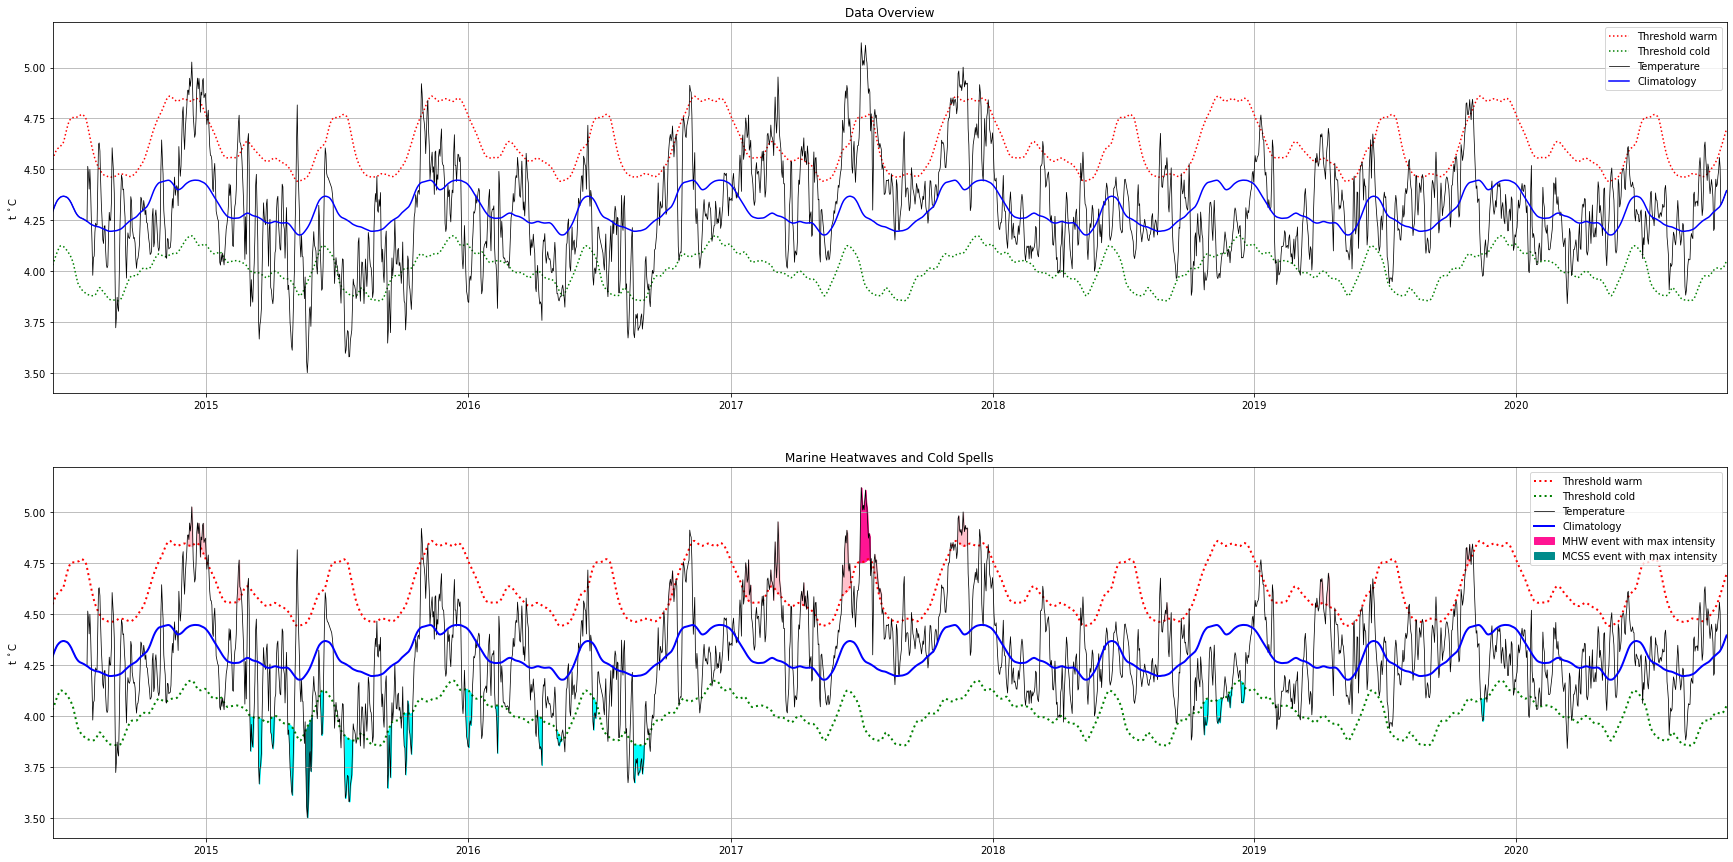

In [37]:
ALL_events(WEST, 1500)

## Plotting some stats code also from example_synthetic.ipynb 

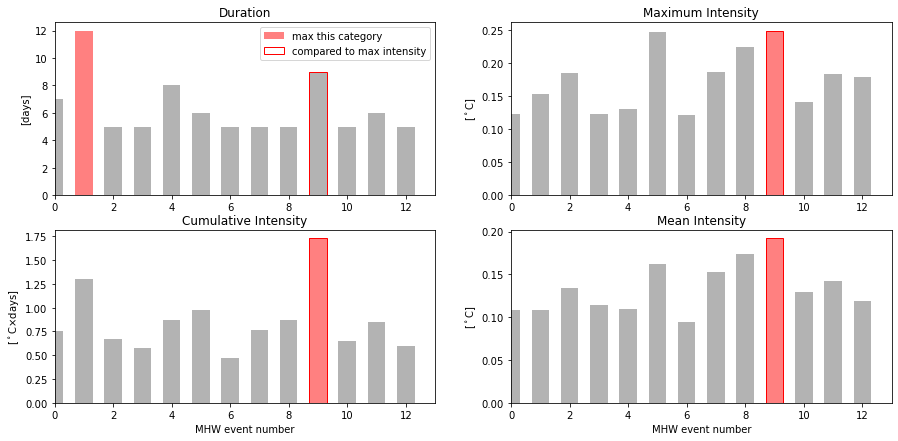

In [38]:
plt.figure(figsize=(15,7))

ev = np.argmax(mhws['intensity_max'])

# Duration
plt.subplot(2,2,1)
evMax = np.argmax(mhws['duration'])
plt.bar(range(mhws['n_events']), mhws['duration'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['duration'][evMax], width=0.6, color=(1,0.5,0.5), label = 'max this category')
plt.bar(ev, mhws['duration'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none', label = 'compared to max intensity')
plt.xlim(0, mhws['n_events'])
plt.ylabel('[days]')
plt.legend()
plt.title('Duration')

# Maximum intensity
plt.subplot(2,2,2)
evMax = np.argmax(mhws['intensity_max'])
plt.bar(range(mhws['n_events']), mhws['intensity_max'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['intensity_max'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws['intensity_max'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.ylabel(r'[$^\circ$C]')
plt.title('Maximum Intensity')

# Mean intensity
plt.subplot(2,2,4)
evMax = np.argmax(mhws['intensity_mean'])
plt.bar(range(mhws['n_events']), mhws['intensity_mean'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['intensity_mean'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws['intensity_mean'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.title('Mean Intensity')
plt.ylabel(r'[$^\circ$C]')
plt.xlabel('MHW event number')

# Cumulative intensity
plt.subplot(2,2,3)
evMax = np.argmax(mhws['intensity_cumulative'])
plt.bar(range(mhws['n_events']), mhws['intensity_cumulative'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['intensity_cumulative'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws['intensity_cumulative'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.title(r'Cumulative Intensity')
plt.ylabel(r'[$^\circ$C$\times$days]')
plt.xlabel('MHW event number');

## More copied code

In [39]:
# some stats

mean, trend, dtrend = mhw.meanTrend(mhwBlock)
print("There are on average " + str(mean['count']) + " MHWs in each year, \n \
with a linear trend of " + str(trend['count']) + " MHW events per year \n \
This trend is statistically significant (p<0.05): " \
+ str(np.abs(trend['count']) > dtrend['count']) + "\n")

print ("The average maximum intensity is " + str(mean['intensity_max']) + " deg. C, \n \
with a linear trend of " + str(trend['intensity_max']) + " deg. C per year \n \
This trend is statistically significant (p<0.05): " \
+ str(np.abs(trend['intensity_max']) > dtrend['intensity_max']))

There are on average 2.2857142857142856 MHWs in each year, 
 with a linear trend of 0.10714285714285705 MHW events per year 
 This trend is statistically significant (p<0.05): False

The average maximum intensity is 0.5577502591855337 deg. C, 
 with a linear trend of -0.019145526380583023 deg. C per year 
 This trend is statistically significant (p<0.05): False
